In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, utils
from tensorflow.data import Dataset
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

# ===================== CONFIGURACIÓN =====================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parámetros del modelo
IMAGE_SIZE = 512
CHANNELS = 11  # 3 canales RGB + 8 morfométricos
NUM_CLASSES = 4  # Fondo + 3 tipos de remoción
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 3e-5

# Rutas (¡AJUSTAR ESTAS!)
DATA_BASE_PATH = "E:/Memoria/CNN/Datasets_Final/dataset_multi"
MODEL_SAVE_PATH = r"E:\Memoria\CNN\Modelos_finales\hrnet_cbam.keras"

# %%


In [2]:
# ===================== CARGA DE DATOS =====================
def load_split(base_path, split, means=None, stds=None):
    """Carga un split completo (train/val/test)"""
    images_dir = os.path.join(base_path, split, "images")
    masks_dir = os.path.join(base_path, split, "masks")
    
    # Cargar y ordenar archivos
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.npy')])
    mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.npy')])
    
    # Cargar datos
    images = np.array([np.load(f) for f in image_files], dtype=np.float32)
    masks = np.array([np.load(f) for f in mask_files])
    
    # Normalización usando estadísticas del train
    if means is not None and stds is not None:
        images = (images - means) / stds
    
    # One-hot encoding para máscaras
    masks = tf.one_hot(masks.astype(np.int32), depth=NUM_CLASSES).numpy()
    
    return images, masks

# Cargar primero el train para calcular estadísticas
X_train, y_train = load_split(DATA_BASE_PATH, "train")
train_means = np.mean(X_train, axis=(0,1,2))
train_stds = np.std(X_train, axis=(0,1,2))

# Recargar todos los splits con normalización consistente
X_train, y_train = load_split(DATA_BASE_PATH, "train", train_means, train_stds)
X_val, y_val = load_split(DATA_BASE_PATH, "val", train_means, train_stds)
X_test, y_test = load_split(DATA_BASE_PATH, "test", train_means, train_stds)



In [3]:
# %%
# ===================== CÁLCULO DE PESOS =====================
def calculate_class_weights(masks):
    class_counts = np.zeros(NUM_CLASSES)
    for mask in masks:
        cls, counts = np.unique(np.argmax(mask, axis=-1), return_counts=True)
        for c, cnt in zip(cls, counts):
            class_counts[c] += cnt
    
    class_counts = np.where(class_counts == 0, 1e-6, class_counts)
    weights = 1.0 / (class_counts / np.sum(class_counts))
    return weights / np.sum(weights)

class_weights = calculate_class_weights(y_train)
print("Pesos calculados:", class_weights)



Pesos calculados: [0.00458703 0.27324145 0.52329437 0.19887715]


In [4]:
# %%
# ===================== FUNCIÓN DE PÉRDIDA =====================
class WeightedFocalLoss(CategoricalFocalCrossentropy):
    def __init__(self, alpha, gamma=2.0, name='weighted_focal_loss'):
        super().__init__(alpha=alpha, gamma=gamma, name=name)
        
    def call(self, y_true, y_pred):
        return super().call(y_true, y_pred)



In [5]:
# %%
# ===================== AUMENTO DE DATOS =====================
def augment_data(image, mask):
    # Flip aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    # Rotación de 90°
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)
    
    # Ajuste de brillo solo para canales RGB
    if tf.random.uniform(()) > 0.5:
        rgb_channels = image[..., :3] * tf.random.uniform([], 0.8, 1.2)
        image = tf.concat([rgb_channels, image[..., 3:]], axis=-1)
    
    # Ruido gaussiano para canales morfométricos
    noise = tf.random.normal(tf.shape(image[..., 3:]), mean=0.0, stddev=0.02)
    image = tf.concat([image[..., :3], image[..., 3:] + noise], axis=-1)
    
    return image, mask



In [6]:

# ===================== ARQUITECTURA HRNet + CBAM =====================
class ChannelAttention(layers.Layer):
    def __init__(self, filters, ratio=8):
        super().__init__()
        self.filters = filters
        self.ratio = ratio
        self.gap = layers.GlobalAveragePooling2D()
        self.gmp = layers.GlobalMaxPooling2D()
        
        self.dense = tf.keras.Sequential([
            layers.Dense(filters//ratio, activation='relu', use_bias=False),
            layers.Dense(filters, use_bias=False)
        ])
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, inputs):
        gap = self.dense(self.gap(inputs))
        gmp = self.dense(self.gmp(inputs))
        att = self.sigmoid(gap + gmp)
        return inputs * att[:, None, None, :]

class SpatialAttention(layers.Layer):
    def __init__(self):
        super().__init__()
        self.conv = layers.Conv2D(1, 7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        mx = tf.reduce_max(inputs, axis=-1, keepdims=True)
        att = self.conv(tf.concat([avg, mx], axis=-1))
        return inputs * att

def CBAM(inputs, filters):
    x = ChannelAttention(filters)(inputs)
    x = SpatialAttention()(x)
    return x

def HRNet_Block(inputs, filters, downsample=False):
    stride = 2 if downsample else 1
    shortcut = inputs
    
    # Bloque principal
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Shortcut connection
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

def build_hrnet_cbam():
    inputs = layers.Input((IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    
    # ------------------------- Rama de Alta Resolución -------------------------
    x_high = HRNet_Block(inputs, 64)
    x_high = HRNet_Block(x_high, 64)
    x_high = CBAM(x_high, 64)
    
    # ------------------------- Rama de Baja Resolución -------------------------
    x_low = layers.MaxPooling2D(2)(x_high)
    x_low = HRNet_Block(x_low, 128)
    x_low = HRNet_Block(x_low, 128)
    x_low = CBAM(x_low, 128)
    
    # ------------------------- Fusión Multi-Escala -------------------------
    # Upsample baja resolución y concatena con alta
    x_low_up = layers.UpSampling2D(2, interpolation='bilinear')(x_low)
    fused = layers.Concatenate()([x_high, x_low_up])
    
    # Bloque final de atención
    fused = CBAM(fused, 64 + 128)
    
    # ------------------------- Decodificación -------------------------
    x = HRNet_Block(fused, 64)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(x)
    
    return Model(inputs, outputs)


In [7]:

model = build_hrnet_cbam()
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      6,400 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 512, 512,  │        768 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 512, 512,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 512, 512,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 512, 512,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 512, 512,  │          0 │ add_1[0][0]     

 Total params: 859,245 (3.28 MB)

 Trainable params: 856,941 (3.27 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [8]:

# ===================== ENTRENAMIENTO =====================
# Preparar datasets
train_dataset = Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment_data).shuffle(100).batch(BATCH_SIZE).prefetch(2)

val_dataset = Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Compilar modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=WeightedFocalLoss(alpha=class_weights),
    metrics=[
        tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES, name='iou'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou',
        patience=20,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        save_best_only=True,
        monitor='val_iou',
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=1e-7
    )
]

# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 290s 29s/step - iou: 0.1231 - loss: 0.0178 - precision: 0.5473 - recall: 0.1998 - val_iou: 0.0096 - val_loss: 0.0130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 228s 25s/step - iou: 0.1204 - loss: 0.0180 - precision: 0.5616 - recall: 0.1724 - val_iou: 0.0093 - val_loss: 0.0128 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 233s 26s/step - iou: 0.1156 - loss: 0.0168 - precision: 0.5230 - recall: 0.1334 - val_iou: 0.0093 - val_loss: 0.0128 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 209s 24s/step - iou: 0.1213 - loss: 0.0137 - precision: 0.5767 - recall: 0.1394 - val_iou: 0.0093 - val_loss: 0.0127 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 194s 24s/step - iou: 0.1241 

In [9]:

# ===================== EVALUACIÓN =====================
# Resultados finales
test_results = model.evaluate(test_dataset, verbose=0)
print("\n=== RESULTADOS FINALES ===")
print(f"Loss: {test_results[0]:.4f}")
print(f"IoU: {test_results[1]:.4f}")
print(f"Precisión: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

# Reporte de clasificación
y_pred = model.predict(test_dataset)
y_true = np.argmax(y_test, axis=-1).flatten()
y_pred = np.argmax(y_pred, axis=-1).flatten()

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=['Fondo', 'Remoción 1', 'Remoción 2', 'Remoción 3']
))

print("\nCoeficiente de Matthews:", matthews_corrcoef(y_true, y_pred))


# %%



=== RESULTADOS FINALES ===
Loss: 0.0175
IoU: 0.1970
Precisión: 0.7667
Recall: 0.4030
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

       Fondo       0.94      0.71      0.81   4631647
  Remoción 1       0.14      0.01      0.02    124412
  Remoción 2       0.02      0.74      0.03     16164
  Remoción 3       0.10      0.37      0.16    208513

    accuracy                           0.68   4980736
   macro avg       0.30      0.46      0.25   4980736
weighted avg       0.88      0.68      0.76   4980736


Coeficiente de Matthews: 0.07185828856620628


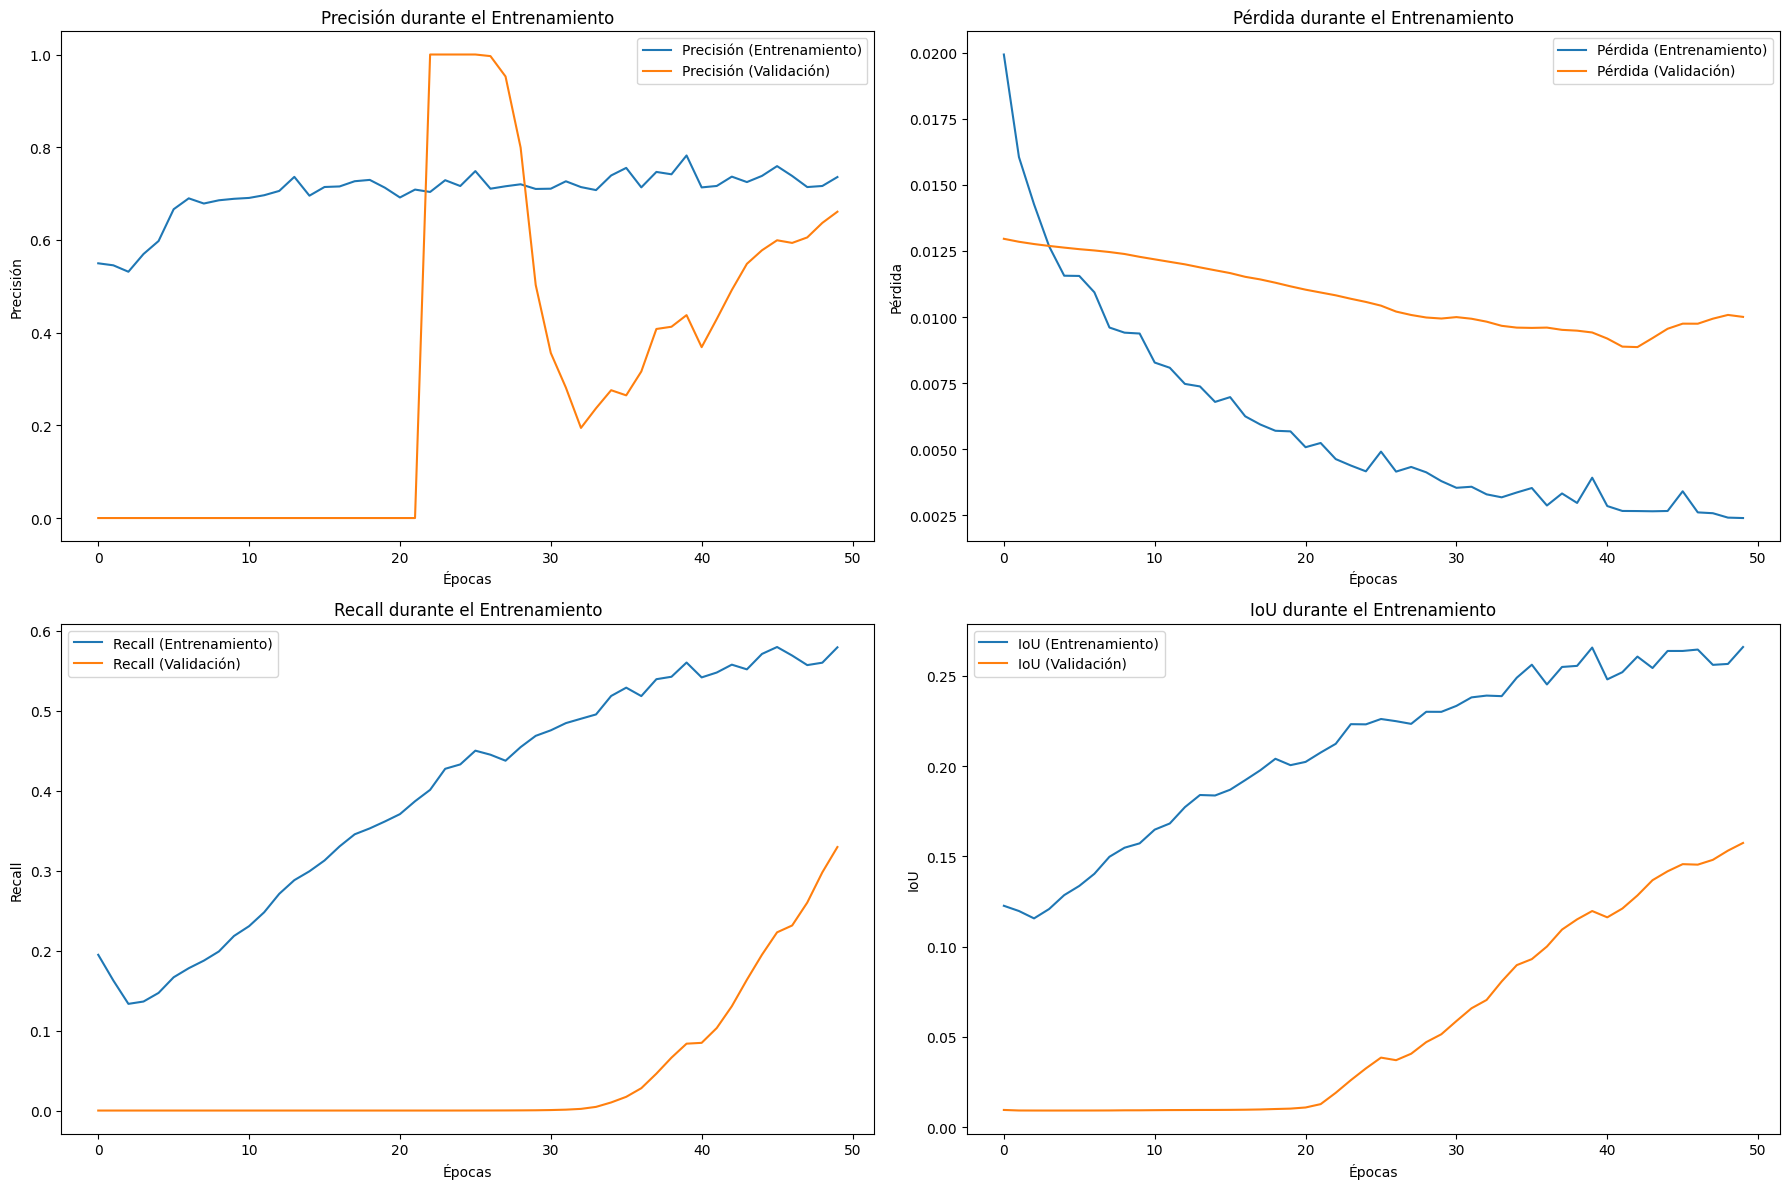

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


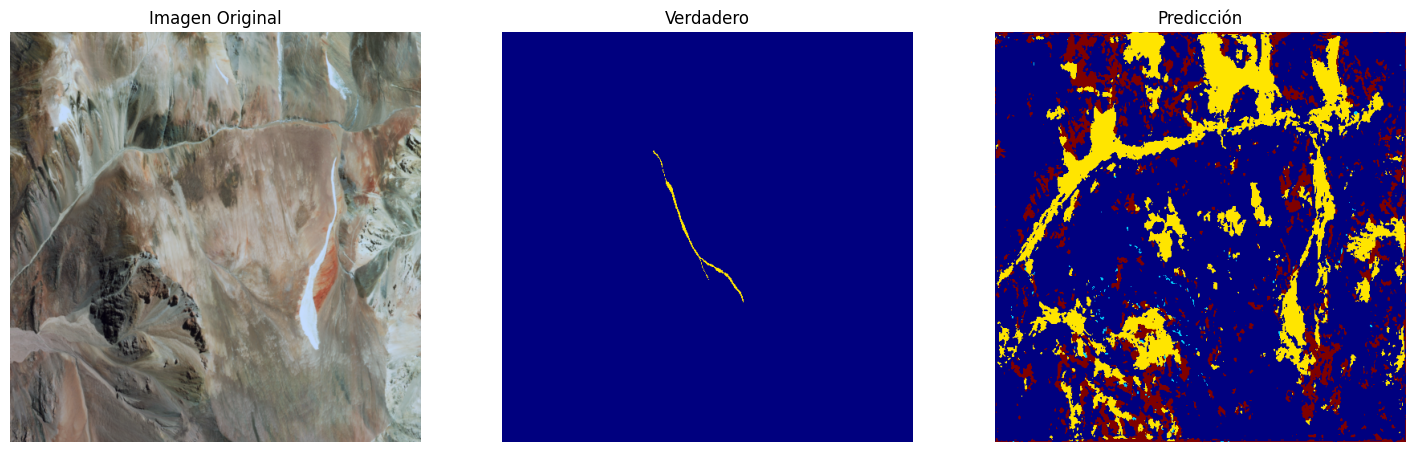

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


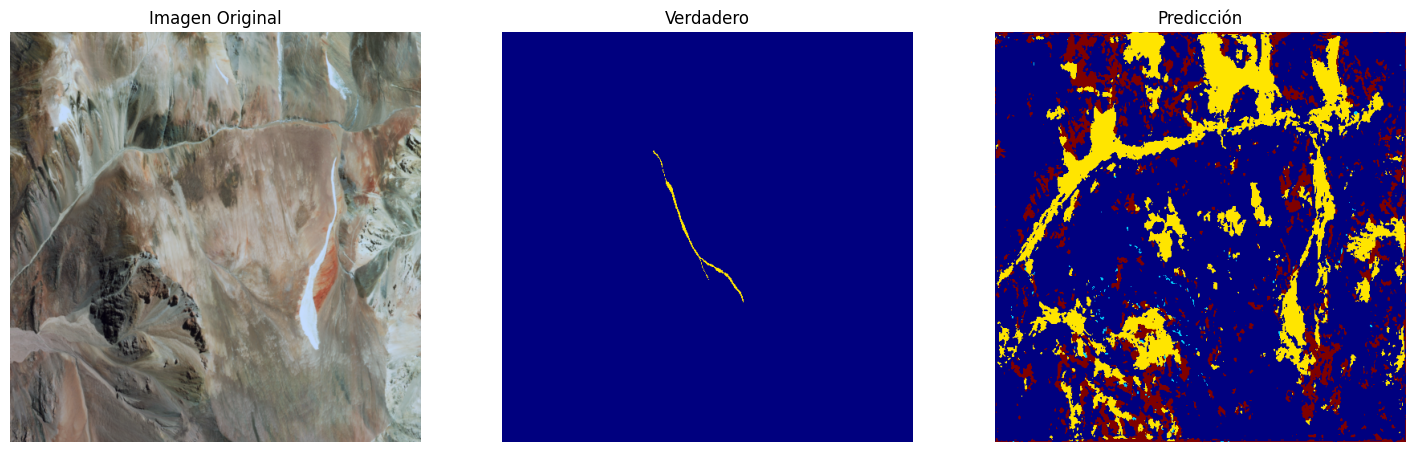

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


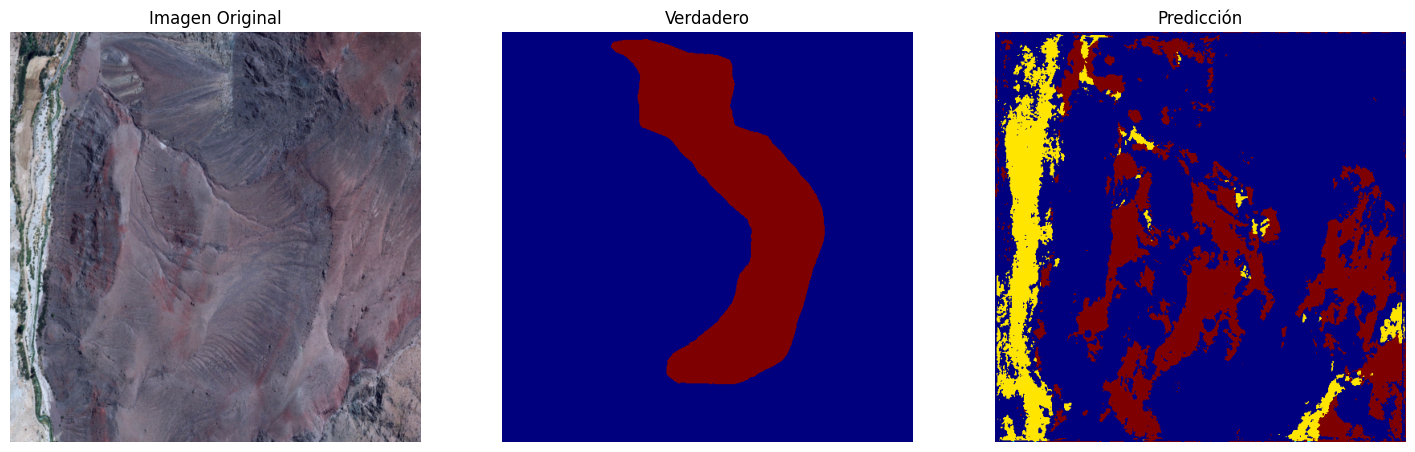

In [12]:

# %% ===================== VISUALIZACIÓN =====================
# ===================== GRÁFICOS DE COMPORTAMIENTO DEL ENTRENAMIENTO =====================
def plot_training_history(history):
    """Grafica la precisión y la pérdida durante el entrenamiento y la validación."""
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_precision = history.history['precision']
    val_precision = history.history['val_precision']
    train_recall = history.history['recall']
    val_recall = history.history['val_recall']
    train_iou = history.history['iou']
    val_iou = history.history['val_iou']
    
    plt.figure(figsize=(18, 12))
    
    # Gráfico de Precisión
    plt.subplot(2, 2, 1)
    plt.plot(train_precision, label='Precisión (Entrenamiento)')
    plt.plot(val_precision, label='Precisión (Validación)')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    
    # Gráfico de Pérdida
    plt.subplot(2, 2, 2)
    plt.plot(train_loss, label='Pérdida (Entrenamiento)')
    plt.plot(val_loss, label='Pérdida (Validación)')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Gráfico de Recall
    plt.subplot(2, 2, 3)
    plt.plot(train_recall, label='Recall (Entrenamiento)')
    plt.plot(val_recall, label='Recall (Validación)')
    plt.title('Recall durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()
    
    # Gráfico de IoU
    plt.subplot(2, 2, 4)
    plt.plot(train_iou, label='IoU (Entrenamiento)')
    plt.plot(val_iou, label='IoU (Validación)')
    plt.title('IoU durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

def plot_predictions(num_samples=3):
    indices = np.random.choice(len(X_test), num_samples)
    
    for idx in indices:
        image = X_test[idx]
        true_mask = y_test[idx]
        pred_mask = model.predict(image[np.newaxis, ...])[0]
        
        plt.figure(figsize=(18, 6))
        
        # Imagen original (primeros 3 canales como RGB)
        plt.subplot(1, 3, 1)
        img_rgb = image[..., :3]
        img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())  # Normalizar
        img_rgb = (img_rgb * 255).astype(np.uint8)  # Escalar a [0, 255]
        plt.imshow(img_rgb)
        plt.title("Imagen Original")
        plt.axis("off")
        
        # Máscara verdadera
        plt.subplot(1, 3, 2)
        plt.imshow(np.argmax(true_mask, axis=-1), cmap='jet', vmin=0, vmax=3)
        plt.title('Verdadero')
        plt.axis('off')
        
        # Predicción
        plt.subplot(1, 3, 3)
        plt.imshow(np.argmax(pred_mask, axis=-1), cmap='jet', vmin=0, vmax=3)
        plt.title('Predicción')
        plt.axis('off')
        
        plt.show()

plot_predictions()


